In [1]:
import platform

# Install openvino-dev package
%pip install -q "openvino-dev>=2024.0.0"  onnx torch pillow opencv-python --extra-index-url https://download.pytorch.org/whl/cpu

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import platform
import os
from pathlib import Path
from typing import Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt
import openvino as ov
from IPython.display import Markdown, display
from PIL import Image

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

import notebook_utils as utils

In [3]:
# A directory where the model will be downloaded.
base_model_dir = Path("model")
# The name of the model from Open Model Zoo.
detection_model_name = "vehicle-detection-0200"
recognition_model_name = "vehicle-attributes-recognition-barrier-0039"
# Selected precision (FP32, FP16, FP16-INT8)
precision = "FP32"

base_model_url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1"

# Check if the model exists.
detection_model_url = f"{base_model_url}/{detection_model_name}/{precision}/{detection_model_name}.xml"
recognition_model_url = f"{base_model_url}/{recognition_model_name}/{precision}/{recognition_model_name}.xml"
detection_model_path = (base_model_dir / detection_model_name).with_suffix(".xml")
recognition_model_path = (base_model_dir / recognition_model_name).with_suffix(".xml")

# Download the detection model.
if not detection_model_path.exists():
    utils.download_file(detection_model_url, detection_model_name + ".xml", base_model_dir)
    utils.download_file(
        detection_model_url.replace(".xml", ".bin"),
        detection_model_name + ".bin",
        base_model_dir,
    )
# Download the recognition model.
if not os.path.exists(recognition_model_path):
    utils.download_file(recognition_model_url, recognition_model_name + ".xml", base_model_dir)
    utils.download_file(
        recognition_model_url.replace(".xml", ".bin"),
        recognition_model_name + ".bin",
        base_model_dir,
    )


In [4]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["CPU"],
    value="CPU",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'GPU', 'CPU'), value='CPU')

In [5]:
# Initialize OpenVINO Runtime runtime.
core = ov.Core()


def model_init(model_path: str) -> Tuple:
    """
    Read the network and weights from file, load the
    model on the CPU and get input and output names of nodes

    :param: model: model architecture path *.xml
    :retuns:
            input_key: Input node network
            output_key: Output node network
            exec_net: Encoder model network
            net: Model network
    """

    # Read the network and corresponding weights from a file.
    model = core.read_model(model=model_path)
    compiled_model = core.compile_model(model=model, device_name=device.value)
    # Get input and output names of nodes.
    input_keys = compiled_model.input(0)
    output_keys = compiled_model.output(0)
    return input_keys, output_keys, compiled_model

In [6]:
# de -> detection
# re -> recognition
# Detection model initialization.
input_key_de, output_keys_de, compiled_model_de = model_init(detection_model_path)
# Recognition model initialization.
input_key_re, output_keys_re, compiled_model_re = model_init(recognition_model_path)

# Get input size - Detection.
height_de, width_de = list(input_key_de.shape)[2:]
# Get input size - Recognition.
height_re, width_re = list(input_key_re.shape)[2:]

In [37]:
def plt_show(raw_image):
    """
    Use matplot to show image inline
    raw_image: input image

    :param: raw_image:image array
    """
    plt.figure(figsize=(10, 6))
    plt.axis("off")
    plt.imshow(raw_image)

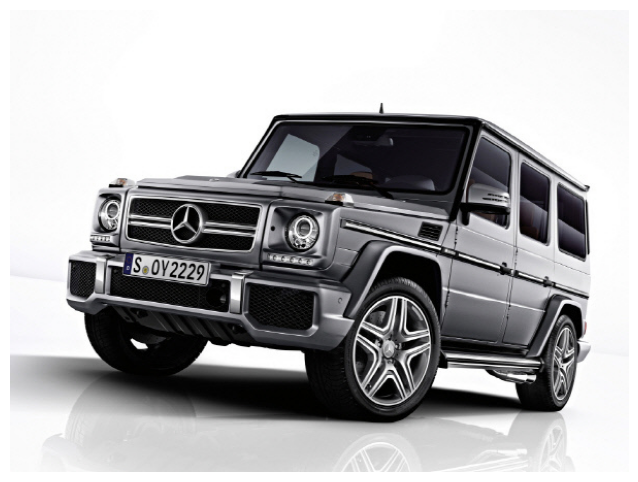

In [88]:
# Read the image.
image_de = cv2.imread("data/asd.jpg")
# Resize it to [3, 256, 256].
resized_image_de = cv2.resize(image_de, (width_de, height_de))
# Expand the batch channel to [1, 3, 256, 256].
input_image_de = np.expand_dims(resized_image_de.transpose(2, 0, 1), 0)
# Show the image.
plt_show(cv2.cvtColor(image_de, cv2.COLOR_BGR2RGB))

In [89]:
# Run inference.
boxes = compiled_model_de([input_image_de])[output_keys_de]
# Delete the dim of 0, 1.
boxes = np.squeeze(boxes, (0, 1))
# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]

In [90]:
def crop_images(bgr_image, resized_image, boxes, threshold=0.6) -> np.ndarray:
    """
    Use bounding boxes from detection model to find the absolute car position

    :param: bgr_image: raw image
    :param: resized_image: resized image
    :param: boxes: detection model returns rectangle position
    :param: threshold: confidence threshold
    :returns: car_position: car's absolute position
    """
    # Fetch image shapes to calculate ratio
    (real_y, real_x), (resized_y, resized_x) = (
        bgr_image.shape[:2],
        resized_image.shape[:2],
    )
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Find the boxes ratio
    boxes = boxes[:, 2:]
    # Store the vehicle's position
    car_position = []
    # Iterate through non-zero boxes
    for box in boxes:
        # Pick confidence factor from last place in array
        conf = box[0]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio
            # In case that bounding box is found at the top of the image,
            # upper box  bar should be positioned a little bit lower to make it visible on image
            (x_min, y_min, x_max, y_max) = [
                (int(max(corner_position * ratio_y * resized_y, 10)) if idx % 2 else int(corner_position * ratio_x * resized_x))
                for idx, corner_position in enumerate(box[1:])
            ]

            car_position.append([x_min, y_min, x_max, y_max])

    return car_position


In [91]:
car_position = crop_images(image_de, resized_image_de, boxes)

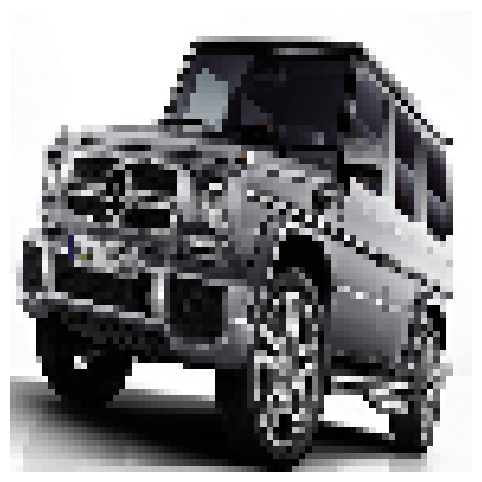

In [92]:
pos = car_position[0]
# Crop the image with [y_min:y_max, x_min:x_max].
test_car = image_de[pos[1] : pos[3], pos[0] : pos[2]]
# Resize the image to input_size.
resized_image_re = cv2.resize(test_car, (width_re, height_re))
input_image_re = np.expand_dims(resized_image_re.transpose(2, 0, 1), 0)
plt_show(cv2.cvtColor(resized_image_re, cv2.COLOR_BGR2RGB))

In [93]:
def vehicle_recognition(compiled_model_re, input_size, raw_image):
    """
    Vehicle attributes recognition, input a single vehicle, return attributes
    :param: compiled_model_re: recognition net
    :param: input_size: recognition input size
    :param: raw_image: single vehicle image
    :returns: attr_color: predicted color
                       attr_type: predicted type
    """
    # An attribute of a vehicle.
    colors = ["White", "Gray", "Yellow", "Red", "Green", "Blue", "Black"]
    types = ["Car", "Bus", "Truck", "Van"]

    # Resize the image to input size.
    resized_image_re = cv2.resize(raw_image, input_size)
    input_image_re = np.expand_dims(resized_image_re.transpose(2, 0, 1), 0)

    # Run inference.
    # Predict result.
    predict_colors = compiled_model_re([input_image_re])[compiled_model_re.output(1)]
    # Delete the dim of 2, 3.
    predict_colors = np.squeeze(predict_colors, (2, 3))
    predict_types = compiled_model_re([input_image_re])[compiled_model_re.output(0)]
    predict_types = np.squeeze(predict_types, (2, 3))

    attr_color, attr_type = (
        colors[np.argmax(predict_colors)],
        types[np.argmax(predict_types)],
    )
    return attr_color, attr_type


In [94]:
print(f"Attributes:{vehicle_recognition(compiled_model_re, (72, 72), test_car)}")

Attributes:('Black', 'Car')


In [95]:
def convert_result_to_image(compiled_model_re, bgr_image, resized_image, boxes, threshold=0.6):
    """
    Use Detection model boxes to draw rectangles and plot the result

    :param: compiled_model_re: recognition net
    :param: input_key_re: recognition input key
    :param: bgr_image: raw image
    :param: resized_image: resized image
    :param: boxes: detection model returns rectangle position
    :param: threshold: confidence threshold
    :returns: rgb_image: processed image
    """
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0), "blue": (0, 0, 255)}

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Find positions of cars.
    car_position = crop_images(image_de, resized_image, boxes)

    for x_min, y_min, x_max, y_max in car_position:
        # Run vehicle recognition inference.
        attr_color, attr_type = vehicle_recognition(compiled_model_re, (72, 72), image_de[y_min:y_max, x_min:x_max])

        # Close the window with a vehicle.
        plt.close()

        # Draw a bounding box based on position.
        # Parameters in the `rectangle` function are: image, start_point, end_point, color, thickness.
        rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["red"], 2)

        # Print the attributes of a vehicle.
        # Parameters in the `putText` function are: img, text, org, fontFace, fontScale, color, thickness, lineType.
        rgb_image = cv2.putText(
            rgb_image,
            f"{attr_color} {attr_type}",
            (x_min, y_min - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            2,
            colors["green"],
            10,
            cv2.LINE_AA,
        )

    return rgb_image

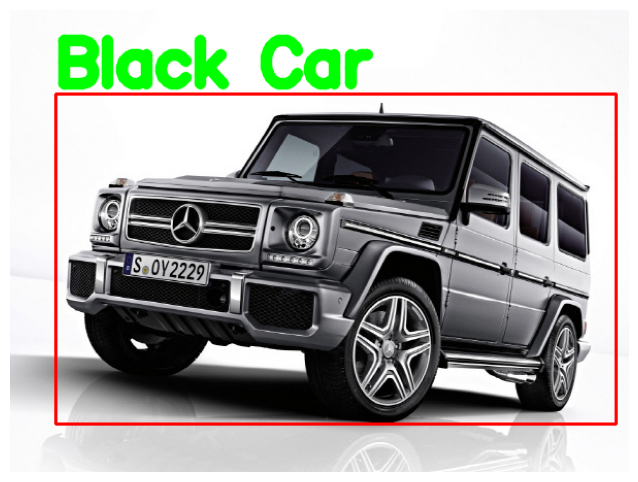

In [96]:
plt_show(convert_result_to_image(compiled_model_re, image_de, resized_image_de, boxes))

In [97]:
def convert_result_crop(compiled_model_re, bgr_image, resized_image, boxes, threshold=0.6):
    """
    Use Detection model boxes to draw rectangles and plot the result

    :param: compiled_model_re: recognition net
    :param: input_key_re: recognition input key
    :param: bgr_image: raw image
    :param: resized_image: resized image
    :param: boxes: detection model returns rectangle position
    :param: threshold: confidence threshold
    :returns: rgb_image: processed image
    """
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0), "blue": (0, 0, 255)}

    # Find positions of cars.
    car_position = crop_images(image_de, resized_image, boxes)

    for x_min, y_min, x_max, y_max in car_position:
        # Run vehicle recognition inference.
        attr_color, attr_type = vehicle_recognition(compiled_model_re, (72, 72), image_de[y_min:y_max, x_min:x_max])

        # Close the window with a vehicle.
        plt.close()

        # Draw a bounding box based on position.
        # Parameters in the `rectangle` function are: image, start_point, end_point, color, thickness.
        rgb_image = bgr_image[y_min:y_max, x_min:x_max]

    return rgb_image

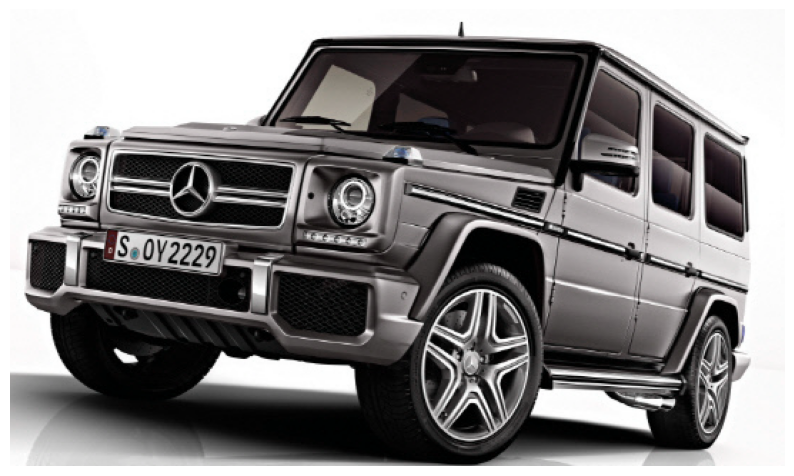

In [98]:
before_ocr = convert_result_crop(compiled_model_re, image_de, resized_image_de, boxes)

plt_show(before_ocr)

## OCR

In [73]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
from IPython.display import Markdown, display
from PIL import Image

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)
from notebook_utils import load_image

In [74]:
core = ov.Core()

model_dir = Path("model")
precision = "FP16"
detection_model = "horizontal-text-detection-0001"
recognition_model = "text-recognition-resnet-fc"

model_dir.mkdir(exist_ok=True)

In [75]:
download_command = (
    f"omz_downloader --name {detection_model},{recognition_model} --output_dir {model_dir} --cache_dir {model_dir} --precision {precision}  --num_attempts 5"
)
display(Markdown(f"Download command: `{download_command}`"))
display(Markdown(f"Downloading {detection_model}, {recognition_model}..."))
!$download_command

detection_model_path = (model_dir / "intel/horizontal-text-detection-0001" / precision / detection_model).with_suffix(".xml")
recognition_model_path = (model_dir / "public/text-recognition-resnet-fc" / precision / recognition_model).with_suffix(".xml")

Download command: `omz_downloader --name horizontal-text-detection-0001,text-recognition-resnet-fc --output_dir model --cache_dir model --precision FP16  --num_attempts 5`

Downloading horizontal-text-detection-0001, text-recognition-resnet-fc...

################|| Downloading horizontal-text-detection-0001 ||################

========== Retrieving model/intel/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.xml from the cache

========== Retrieving model/intel/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.bin from the cache

################|| Downloading text-recognition-resnet-fc ||################

========== Retrieving model/public/text-recognition-resnet-fc/vedastr/models/__init__.py from the cache

========== Retrieving model/public/text-recognition-resnet-fc/vedastr/models/builder.py from the cache

========== Retrieving model/public/text-recognition-resnet-fc/vedastr/models/model.py from the cache

========== Retrieving model/public/text-recognition-resnet-fc/vedastr/models/weight_init.py from the cache

========== Retrieving model/public/text-recognition-resnet-fc/vedastr/models/registry.py from the cache

========== Retrieving model/public/text-recognition-resnet-fc/vedastr/mode

In [76]:
convert_command = f"omz_converter --name {recognition_model} --precisions {precision} --download_dir {model_dir} --output_dir {model_dir}"
display(Markdown(f"Convert command: `{convert_command}`"))
display(Markdown(f"Converting {recognition_model}..."))
! $convert_command

Convert command: `omz_converter --name text-recognition-resnet-fc --precisions FP16 --download_dir model --output_dir model`

Converting text-recognition-resnet-fc...

========== Converting text-recognition-resnet-fc to ONNX
Conversion to ONNX command: /home/ubuntu/workdir/.venv/bin/python3 -- /home/ubuntu/workdir/.venv/lib/python3.10/site-packages/omz_tools/internal_scripts/pytorch_to_onnx.py --model-path=/home/ubuntu/workdir/.venv/lib/python3.10/site-packages/omz_tools/models/public/text-recognition-resnet-fc --model-path=model/public/text-recognition-resnet-fc --model-name=get_model --import-module=model '--model-param=file_config=r"model/public/text-recognition-resnet-fc/vedastr/configs/resnet_fc.py"' '--model-param=weights=r"model/public/text-recognition-resnet-fc/vedastr/ckpt/resnet_fc.pth"' --input-shape=1,1,32,100 --input-names=input --output-names=output --output-file=model/public/text-recognition-resnet-fc/resnet_fc.onnx

ONNX check passed successfully.

========== Converting text-recognition-resnet-fc to IR (FP16)
Conversion command: /home/ubuntu/workdir/.venv/bin/python3 -- /home/ubuntu/workdir/.venv/bin/mo --framework=onnx --output_dir=m

In [77]:
detection_model = core.read_model(model=detection_model_path, weights=detection_model_path.with_suffix(".bin"))
detection_compiled_model = core.compile_model(model=detection_model, device_name=device.value)

detection_input_layer = detection_compiled_model.input(0)

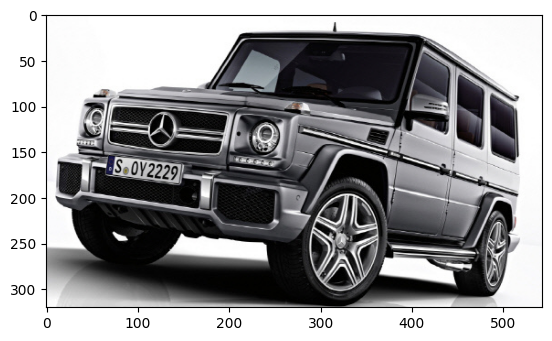

In [78]:
image = before_ocr

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = detection_input_layer.shape

# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

In [79]:
output_key = detection_compiled_model.output("boxes")
boxes = detection_compiled_model([input_image])[output_key]

# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]

In [80]:
def multiply_by_ratio(ratio_x, ratio_y, box):
    return [max(shape * ratio_y, 10) if idx % 2 else shape * ratio_x for idx, shape in enumerate(box[:-1])]


def run_preprocesing_on_crop(crop, net_shape):
    temp_img = cv2.resize(crop, net_shape)
    temp_img = temp_img.reshape((1,) * 2 + temp_img.shape)
    return temp_img


def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0), "white": (255, 255, 255)}

    # Fetch image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box, annotation in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply position of each box by x and y ratio.
            (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, box))

            # Draw a box based on the position. Parameters in the `rectangle` function are: image, start_point, end_point, color, thickness.
            cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add a text to an image based on the position and confidence. Parameters in the `putText` function are: image, text, bottomleft_corner_textfield, font, font_scale, color, thickness, line_type
            if conf_labels:
                # Create a background box based on annotation length.
                (text_w, text_h), _ = cv2.getTextSize(f"{annotation}", cv2.FONT_HERSHEY_TRIPLEX, 0.8, 1)
                image_copy = rgb_image.copy()
                cv2.rectangle(
                    image_copy,
                    (x_min, y_min - text_h - 10),
                    (x_min + text_w, y_min - 10),
                    colors["white"],
                    -1,
                )
                # Add weighted image copy with white boxes under a text.
                cv2.addWeighted(image_copy, 0.4, rgb_image, 0.6, 0, rgb_image)
                cv2.putText(
                    rgb_image,
                    f"{annotation}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

In [81]:
recognition_model = core.read_model(model=recognition_model_path, weights=recognition_model_path.with_suffix(".bin"))

recognition_compiled_model = core.compile_model(model=recognition_model, device_name=device.value)

recognition_output_layer = recognition_compiled_model.output(0)
recognition_input_layer = recognition_compiled_model.input(0)

# Get the height and width of the input layer.
_, _, H, W = recognition_input_layer.shape

In [82]:
# Calculate scale for image resizing.
(real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

# Convert the image to grayscale for the text recognition model.
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Get a dictionary to encode output, based on the model documentation.
letters = "~0123456789abcdefghijklmnopqrstuvwxyz"

# Prepare an empty list for annotations.
annotations = list()
cropped_images = list()
# fig, ax = plt.subplots(len(boxes), 1, figsize=(5,15), sharex=True, sharey=True)
# Get annotations for each crop, based on boxes given by the detection model.
for i, crop in enumerate(boxes):
    # Get coordinates on corners of a crop.
    (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, crop))
    image_crop = run_preprocesing_on_crop(grayscale_image[y_min:y_max, x_min:x_max], (W, H))

    # Run inference with the recognition model.
    result = recognition_compiled_model([image_crop])[recognition_output_layer]

    # Squeeze the output to remove unnecessary dimension.
    recognition_results_test = np.squeeze(result)

    # Read an annotation based on probabilities from the output layer.
    annotation = list()
    for letter in recognition_results_test:
        parsed_letter = letters[letter.argmax()]

        # Returning 0 index from `argmax` signalizes an end of a string.
        if parsed_letter == letters[0]:
            break
        annotation.append(parsed_letter)
    annotations.append("".join(annotation))
    cropped_image = Image.fromarray(image[y_min:y_max, x_min:x_max])
    cropped_images.append(cropped_image)

boxes_with_annotations = list(zip(boxes, annotations))

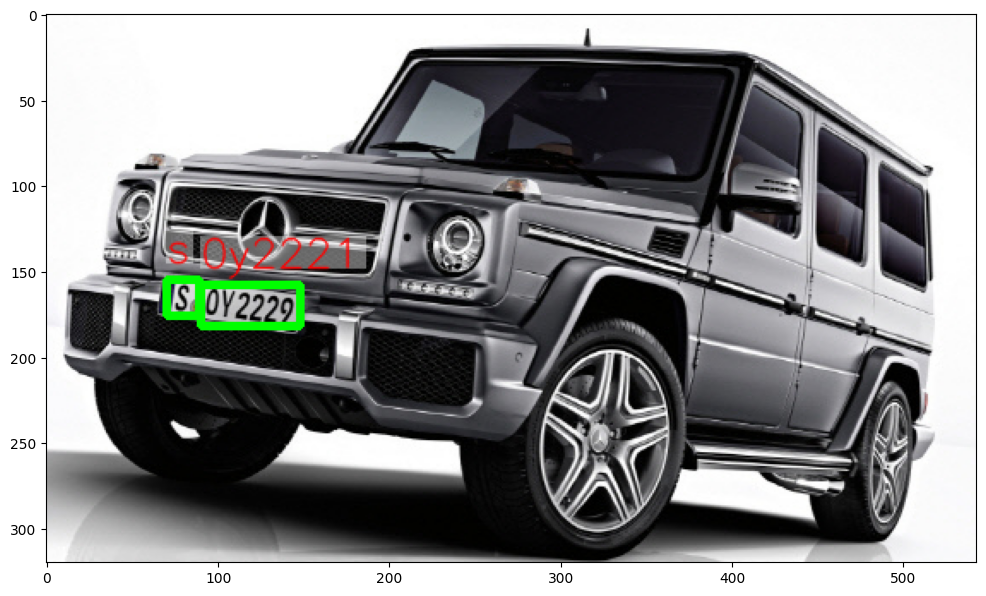

In [83]:
plt.figure(figsize=(12, 12))
plt.imshow(convert_result_to_image(image, resized_image, boxes_with_annotations, conf_labels=True));

In [84]:
print(f"Car status:{vehicle_recognition(compiled_model_re, (72, 72), test_car)}")

Car status:('Black', 'Car')


In [85]:
print(f"Car number")
for num in boxes_with_annotations:
    if (num[0][-1] > 0.3):
        print(num[1], end=" ")

Car number
0y2221 s 